# Residual net for mnist data

In this notebook, we will use `residual` blocks to classify the simple **minist** dataset. The goal is to start from scratch and touch the differences of adding a residual block.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Techniques for loading the dataset

In [4]:
from fastai.vision import *

In [5]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/home/anass/.fastai/data/mnist_png/training'),
 PosixPath('/home/anass/.fastai/data/mnist_png/testing')]

the images are classified by folder. So we will create a `itemList` to load the data

In [16]:
images_list = ImageList.from_folder(path,convert_mode='L')

Let's list a sample from the list.

In [23]:
item0 = images_list[0]
print(type(item0))
print(item0.shape)

<class 'fastai.vision.image.Image'>
torch.Size([1, 28, 28])


let's change the defaults

In [24]:
defaults.cmap='binary'

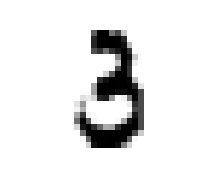

In [25]:
item0.show()

Now let's split the data. This is a **mandatory** step in preparing a databunch. Even in the case with no validation set we split the data by the method `no_split`.

In [28]:
ds = images_list.split_by_folder(train='training',valid='testing')

In [29]:
ds

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/anass/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/anass/.fastai/data/mnist_png;

Test: None

now we label the data

In [30]:
ll = ds.label_from_folder()

In [31]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/anass/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,3,3,3,3
Path: /home/anass/.fastai/data/mnist_png;

Test: None

Now we can obtain the image and it's label

In [32]:
x, y = ll.train[0]

In [34]:
print('x shape is {}, and its label is {}'.format(x.shape,y))

x shape is torch.Size([1, 28, 28]), and its label is 3


### Data transformation
For images of digits, it doesn't make sense to flip the data as the number could change. So we will apply simple transformation by **random padding**.

In [36]:
# the second list is for test transformation
tfms = [[*rand_pad(padding=3, size=28,mode='zeros')], [] ]

In [37]:
ll = ll.transform(tfms)

### Creating the databunch

In [38]:
batch_size = 128
databunch = ll.databunch(bs=batch_size).normalize()

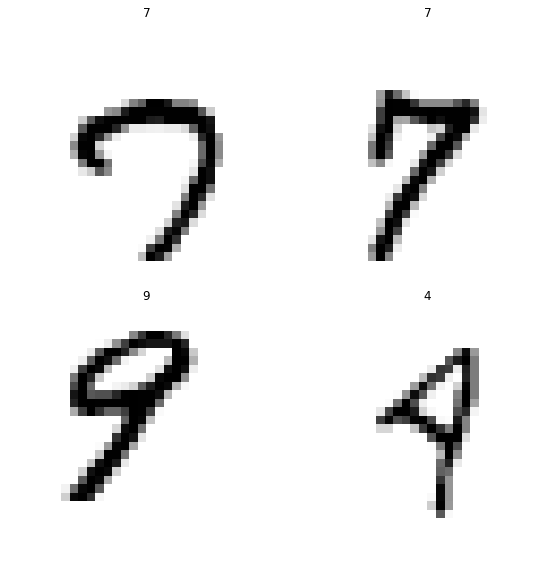

In [40]:
databunch.show_batch(2)

The databunch is still a wrapper around **pytorch** dataloader. This is great as we could still get our tensors

In [41]:
xb, yb = databunch.one_batch()

In [43]:
print(xb.shape)
print(yb.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


## Basic CNN with pytorch

Now that we have a databucnh hat our disposal, we will create our model to classify the data. The basic block is a convolutional layer followed by  a batch normalization and relu non linearity

In [46]:
def conv(input_channels, num_filters):
    return nn.Conv2d(input_channels,num_filters,kernel_size=3, stride=2,padding=1)

Now we can create our model

In [47]:
model = nn.Sequential(
    conv(1,8),   # size now is 14 since the image initial size is (28,28)
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid    
    )

In [50]:
learner = Learner(databunch, model, loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

In [51]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [54]:
#finding the learning rate
learner.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


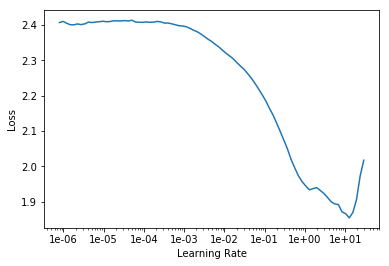

In [55]:
learner.recorder.plot()

In [57]:
learner.fit_one_cycle(1,max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.131661,0.059161,0.981500,00:11


Already a $98\%$ just with vanilla cnn

## Refactoring
The combination * conv-batchnorm-relu* is already implemented in fastai in the `conv_layer`. So we will use it to simplify the model

In [58]:
def conv2(ni, nf):
    return conv_layer(ni,nf,stride=2)

In [59]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [61]:
learn = Learner(databunch, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [62]:
learn.fit_one_cycle(1,max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.138018,0.067164,0.978600,00:11


## Residual blocks

let's define a `residual block` wich use **skip connexions** to make the learning smoother.

--- todo --- add a link the pdf

In [64]:
class ResBlock(nn.Module):
    def __init__(self,nf):
        super().__init__()
        #first convolutional layer
        self.conv1 = nn.Conv2d(nf,nf)
        #second convolutional layer
        self.conv2 = nn.Conv2d(nf,nf)
    
    def forward(self, x):
        return x + self.Conv2d(self.conv1(x))
        

Also this block is already implemented in the fastai as `res_block`

In [65]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [66]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [67]:
learn = Learner(databunch, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


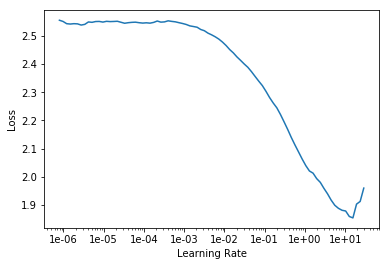

In [68]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(10, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.093930,0.088679,0.972300,00:13
1,0.107395,0.093923,0.970100,00:12
2,0.098909,0.118861,0.962400,00:13
3,0.078475,0.180384,0.944000,00:13
4,0.066429,0.197620,0.931900,00:12
5,0.050383,0.052067,0.983600,00:12
6,0.041822,0.028024,0.991200,00:12
7,0.035556,0.022966,0.992400,00:13
8,0.023810,0.018123,0.994400,00:13
9,0.017932,0.016660,0.994600,00:13
